# Descriptive Analysis of Raw, LDA-Ready, and BERTopic-Ready Datasets

This notebook compares three different Reddit data processing stages:

1. **Raw Data**  
2. **LDA-Ready** Data  
3. **BERTopic-Ready** Data  

Each dataset is loaded, text documents are extracted, key statistics are computed, and vocabulary growth curves are visualised.

In [21]:
# -----------------------------------------------------------------------------
# Cell 1: Imports and Setup
# -----------------------------------------------------------------------------
import json
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from collections import Counter

# For word clouds
from wordcloud import WordCloud

def load_data(file_path: Path):
    """
    Loads and parses JSON data from a file.
    Returns a list of post-like dictionaries.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def extract_docs_raw(data: list):
    """
    Extracts *raw* text from each post (title + selftext)
    plus each comment (comment field).
    Returns a list of documents (strings).
    """
    all_docs = []
    for post in data:
        # Combine post title + selftext
        title = post.get('title', '').strip()
        selftext = post.get('selftext', '').strip()
        main_text = f"{title} {selftext}".strip()
        if main_text:
            all_docs.append(main_text)
        
        # Extract comments
        for c in post.get('comments', []):
            comment_text = c.get('comment', '').strip()
            if comment_text:
                all_docs.append(comment_text)
    return all_docs

def extract_docs_processed(data: list):
    """
    Extracts *processed* text (combined_processed for posts,
    comment_processed for comments).
    Returns a list of documents (strings).
    """
    all_docs = []
    for post in data:
        # Post-level
        combined_proc = post.get('combined_processed', '').strip()
        if combined_proc:
            all_docs.append(combined_proc)

        # Comment-level
        for c in post.get('comments', []):
            c_text = c.get('comment_processed', '').strip()
            if c_text:
                all_docs.append(c_text)
    return all_docs

## Dataset Loading and Basic Exploration

load three datasets (Raw, LDA, BERTopic) and extract text documents. also display a few statistics, such as total documents in each set.

In [23]:
# -----------------------------------------------------------------------------
# Cell 2: Load Datasets and Extract Documents
# -----------------------------------------------------------------------------
data_folder = Path(r"C:\Users\laure\Desktop\dissertation_notebook\Data")

raw_path = data_folder / "aggregated_raw_reddit_data.json"
lda_path = data_folder / "lda_ready_data.json"
bertopic_path = data_folder / "bertopic_ready_data.json"

# Load the data
raw_data = load_data(raw_path)
lda_data = load_data(lda_path)
bertopic_data = load_data(bertopic_path)

# Extract documents
raw_docs = extract_docs_raw(raw_data)
lda_docs = extract_docs_processed(lda_data)
bertopic_docs = extract_docs_processed(bertopic_data)

# Print basic stats
print("Number of Documents in Each Dataset:")
print(f"- Raw Data:       {len(raw_docs)}")
print(f"- LDA-Ready Data: {len(lda_docs)}")
print(f"- BERTopic Data:  {len(bertopic_docs)}")

# Display a small sample from each dataset
print("\nSample from Raw Docs:")
for doc in raw_docs[:2]:
    print(">>>", doc[:100].replace('\n', ' '), "...")

print("\nSample from LDA Docs:")
for doc in lda_docs[:2]:
    print(">>>", doc[:100], "...")

print("\nSample from BERTopic Docs:")
for doc in bertopic_docs[:2]:
    print(">>>", doc[:100], "...")


Number of Documents in Each Dataset:
- Raw Data:       6481
- LDA-Ready Data: 6007
- BERTopic Data:  6479

Sample from Raw Docs:
>>> How do y'all not engage with the Anti ABA people on Reddit? I'm well aware of the beginnings of ABA  ...
>>> You should  check out the autisticpeeps subreddit (subreddit for diagnosed autistics that are agaisn ...

Sample from LDA Docs:
>>> engage anti aba reddit aware beginning aba used aware currently son family_member therapist done lot ...
>>> check autisticpeeps subreddit discussion aba poster credited helping ...

Sample from BERTopic Docs:
>>> how do y'all not engage with the anti aba people on reddit? i'm well aware of the beginnings of aba  ...
>>> you should check out the autisticpeeps subreddit (subreddit for diagnosed autistics that are agaisnt ...


## Vocabulary growth curves

plot how vocabulary size evolvee. This demonstrates relative dataset size and lexical diversity.


In [27]:
# -----------------------------------------------------------------------------
# Cell 3: Visualisation Helpers
# -----------------------------------------------------------------------------
def combined_vocab_growth_curve(docs_list, labels, title, ax=None):
    """
    Compare vocabulary growth curves for multiple datasets in a single plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['blue', 'green', 'red']

    for docs, label, color in zip(docs_list, labels, colors):
        unique_words = set()
        x_vals, y_vals = [], []
        token_counter = 0
        
        for doc in docs:
            tokens = doc.split()
            for t in tokens:
                token_counter += 1
                unique_words.add(t)
                x_vals.append(token_counter)
                y_vals.append(len(unique_words))
        
        # Plot every nth point to reduce clutter if large datasets
        n = max(1, len(x_vals) // 1000)
        ax.plot(x_vals[::n], y_vals[::n],
        color=color,
        label=label,
        alpha=0.7)
    
    ax.set_title(title)
    ax.set_xlabel('Number of Tokens Seen')
    ax.set_ylabel('Vocabulary Size')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()


## Plotting the Vocabulary growth curves

<Figure size 1000x500 with 0 Axes>

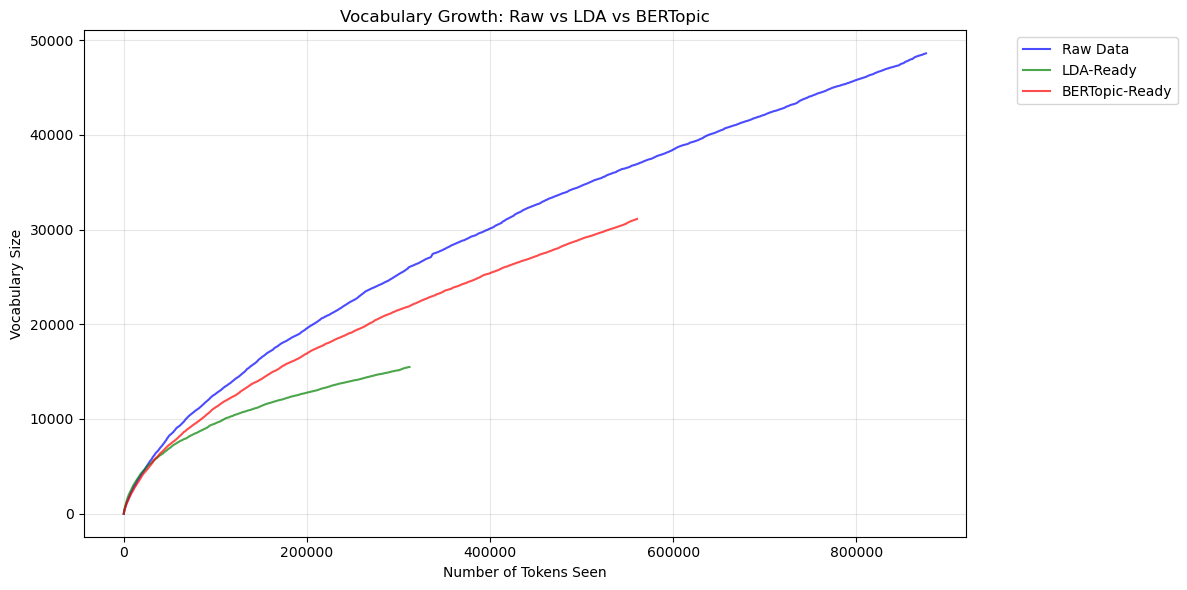

In [29]:
# -----------------------------------------------------------------------------
# Cell 4: Generate the Vocabulary Growth Comparison
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
combined_vocab_growth_curve(
    [raw_docs, lda_docs, bertopic_docs],
    ["Raw Data", "LDA-Ready", "BERTopic-Ready"],
    "Vocabulary Growth: Raw vs LDA vs BERTopic"
)
plt.show()

## Word Clouds

Generate three word clouds (one for each dataset) based on their most frequent tokens. This helps visualise the most dominant words in each corpus.

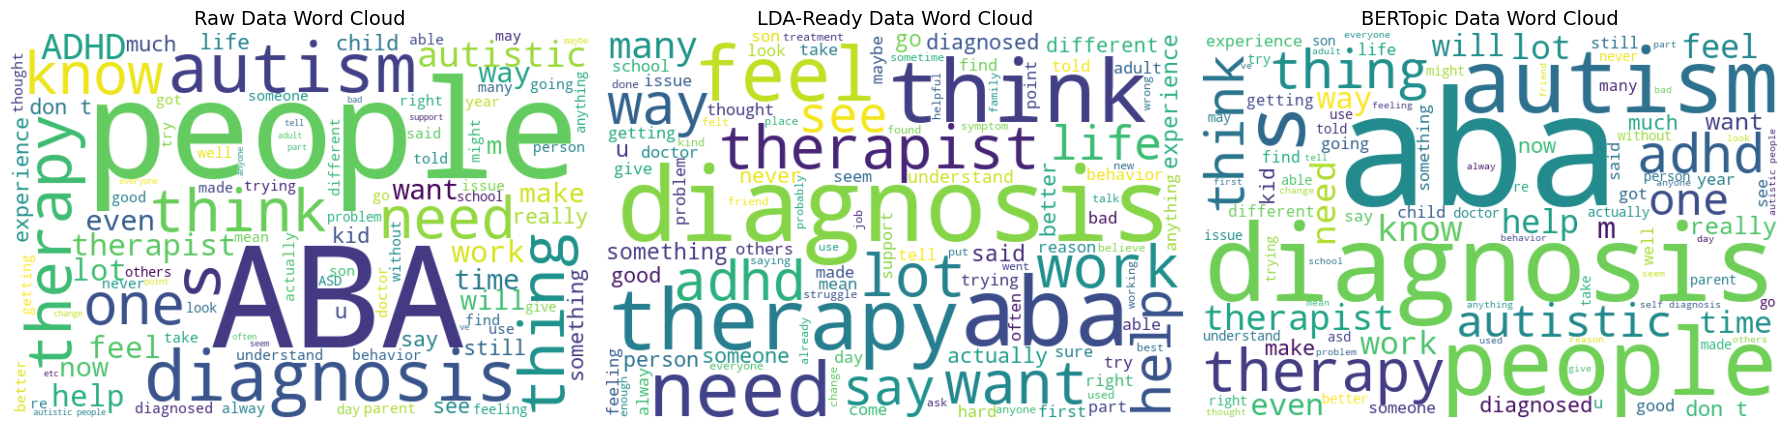

In [17]:
# -----------------------------------------------------------------------------
# Cell 5: Word Clouds
# -----------------------------------------------------------------------------
def plot_wordcloud(docs, title, ax=None):
    """
    Generates and plots a word cloud for a given list of documents.
    """
    from wordcloud import WordCloud
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    # Join docs into one big string
    big_text = " ".join(docs)

    # Create a word cloud
    wc = WordCloud(width=600, height=400, background_color="white",
                   max_words=100, colormap="viridis").generate(big_text)

    # Plot on the provided ax 
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=14)

# Plot side by side or in separate figures
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_wordcloud(raw_docs,        "Raw Data Word Cloud",        ax=axes[0])
plot_wordcloud(lda_docs,        "LDA-Ready Data Word Cloud",  ax=axes[1])
plot_wordcloud(bertopic_docs,   "BERTopic Data Word Cloud",   ax=axes[2])

plt.tight_layout()
plt.show()

## Conclusion
this notebook:
- Loaded three Reddit datasets (Raw, LDA-Ready, BERTopic-Ready).
- Extracted raw or processed text.
- Displayed vocabulary growth curves to compare size and lexical diversity.
- Generated word clouds to visualise key tokens in each corpus.

## References

**Reference:**  
Hunter, J. D. (2007) *Matplotlib: A 2D Graphics Environment* [computer program]. *Computing in Science & Engineering*, 9(3), pp. 90–95 (v3.7.3).  
Available from: [https://matplotlib.org/](https://matplotlib.org/) [Accessed 12 January 2025].

**Git Repo:**  
- [Matplotlib GitHub](https://github.com/matplotlib/matplotlib)

**Reference:**  
McKinney, W. (2010) *Data Structures for Statistical Computing in Python*. *Proceedings of the 9th Python in Science Conference*, pp. 51–56 (v2.2.3).  
Available from: [https://pandas.pydata.org/](https://pandas.pydata.org/) [Accessed 12 January 2025].

**Git Repo:**  
- [Pandas GitHub](https://github.com/pandas-dev/pandas)